In [1]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


In [2]:
import torchvision
from torchvision import models
from torchvision import transforms
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

# when transfer, color value is divided by 255
# PIL image -> tensor
loader = transforms.Compose([transforms.ToTensor()])
# tensor -> PIL image
unloader = transforms.ToPILImage()
preprocess = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# Code: training model

In [3]:
class SegDataset(Dataset):
    def __init__(self, mask_dir, img_dir, img_transform = None):
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.n_mask = len(os.listdir(self.mask_dir))
        self.n_img = len(os.listdir(self.img_dir))
        self.img_transform = img_transform

    def __len__(self):     
        return min(self.n_img, self.n_mask)

    def __getitem__(self, idx):
        
        filename = os.listdir(self.img_dir)[idx]
        
        img_path = f"{self.img_dir}{filename}"
        img = Image.open(img_path).convert("RGB")
        if self.img_transform:
            img = self.img_transform(img)        
        
        mask_path = f"{self.mask_dir}{filename}"
        mask = Image.open(mask_path).convert('L')
#         plt.imshow(mask, cmap="gray")
        mask = np.asarray(mask)
        mask[mask>200]=255    # black:0, white: 255
        mask[mask<=200]=0
        mask = mask/255
#         plt.imshow(mask, cmap="gray")
        mask=mask[np.newaxis,:, :]
        mask = torch.Tensor(mask)

        return img, mask

batch_size = 2
    
train_mask_dir = f"./images/train/mask/"
train_img_dir = f"./images/train/img/"
training_set = SegDataset(train_mask_dir,train_img_dir, preprocess)
training_generator = DataLoader(training_set, batch_size=batch_size, shuffle=True)

val_mask_dir = f"./images/validation/mask/"
val_img_dir = f"./images/validation/img/"
validation_set = SegDataset(val_mask_dir, val_img_dir, preprocess)
validation_generator = DataLoader(validation_set, batch_size=batch_size, shuffle=True)


In [4]:
def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

model = createDeepLabv3()


In [5]:
def get_IOU(output, mask):
    # Use a classification threshold of 0.1
    output = output>0.1
    mask = mask>0
    I = torch.sum(torch.multiply(mask, output))
    U = mask+output
    U = torch.sum(U>0)
    IOU = I.item()/U.item()
    return IOU

In [6]:
def get_accuracy(output, mask):
    # Use a classification threshold of 0.1
    output = output>0.1
    mask = mask>0
    d1, d2, d3, d4 = mask.size()
    I = (mask==output)
    acc = torch.sum(I)/(d1*d2*d3*d4)
    return acc.item()

In [9]:
model.to(device)
num_epochs = 30

# Specify the loss function
criterion = torch.nn.MSELoss()
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epoch_loss = []
epoch_accuracy = []
epoch_IOU = []
for epoch in range(1, num_epochs + 1):
    batch_loss = []
    batch_accuracy = []
    batch_IOU =[]

    for (img, mask) in iter(training_generator):
        model.train()
        optimizer.zero_grad()
        img = img.to(device).to(torch.float32)
        mask = mask.to(device).to(torch.float32)
        output = model(img)['out']
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        batch_loss.append(float(loss)) 
        batch_accuracy.append(float(get_accuracy(output, mask)))
        batch_IOU.append(float(get_IOU(output, mask)))
        
    epoch_loss.append(np.mean(batch_loss))
    epoch_accuracy.append(np.mean(batch_accuracy))
    epoch_IOU.append(np.mean(batch_IOU))
    print(f"Train Epoch {epoch:2}/{num_epochs}: Loss {np.mean(batch_loss):.3f} | Accuracy {np.mean(batch_accuracy):.3f} | IOU {np.mean(batch_IOU):.3f} ")


Train Epoch  1/30: Loss 0.072 | Accuracy 0.751 | IOU 0.635 
Train Epoch  2/30: Loss 0.042 | Accuracy 0.787 | IOU 0.671 
Train Epoch  3/30: Loss 0.033 | Accuracy 0.826 | IOU 0.714 
Train Epoch  4/30: Loss 0.025 | Accuracy 0.896 | IOU 0.791 
Train Epoch  5/30: Loss 0.018 | Accuracy 0.900 | IOU 0.793 
Train Epoch  6/30: Loss 0.017 | Accuracy 0.929 | IOU 0.834 
Train Epoch  7/30: Loss 0.015 | Accuracy 0.939 | IOU 0.855 
Train Epoch  8/30: Loss 0.015 | Accuracy 0.949 | IOU 0.875 
Train Epoch  9/30: Loss 0.014 | Accuracy 0.951 | IOU 0.885 
Train Epoch 10/30: Loss 0.013 | Accuracy 0.953 | IOU 0.884 
Train Epoch 11/30: Loss 0.013 | Accuracy 0.953 | IOU 0.887 
Train Epoch 12/30: Loss 0.012 | Accuracy 0.956 | IOU 0.895 
Train Epoch 13/30: Loss 0.012 | Accuracy 0.957 | IOU 0.895 
Train Epoch 14/30: Loss 0.011 | Accuracy 0.959 | IOU 0.903 
Train Epoch 15/30: Loss 0.011 | Accuracy 0.961 | IOU 0.906 
Train Epoch 16/30: Loss 0.010 | Accuracy 0.963 | IOU 0.910 
Train Epoch 17/30: Loss 0.010 | Accuracy

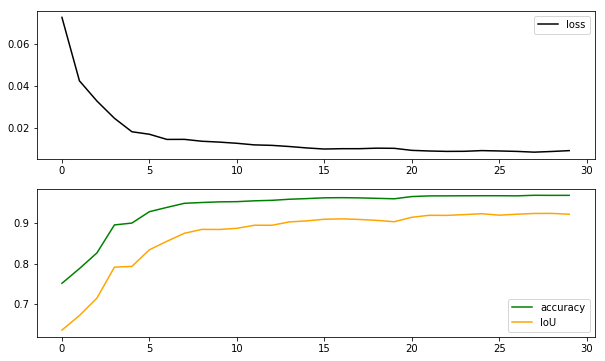

In [30]:
x = range(num_epochs)
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,6))
ax1.plot(x, epoch_loss, "black", label="loss")
ax1.legend(loc="upper right")
ax2.plot(x, epoch_accuracy, "green", label="accuracy")
ax2.plot(x, epoch_IOU, "orange", label="IoU")
ax2.legend(loc="lower right")
plt.show()


In [32]:
torch.save(model, "./trained_model")

# Code: testing model

In [5]:
model = torch.load("./trained_model")

In [34]:
model.eval()
for (img, mask) in iter(validation_generator):
    img = img.to(device).to(torch.float32)
    mask = mask.to(device).to(torch.float32)
    output = model(img)['out']
    break


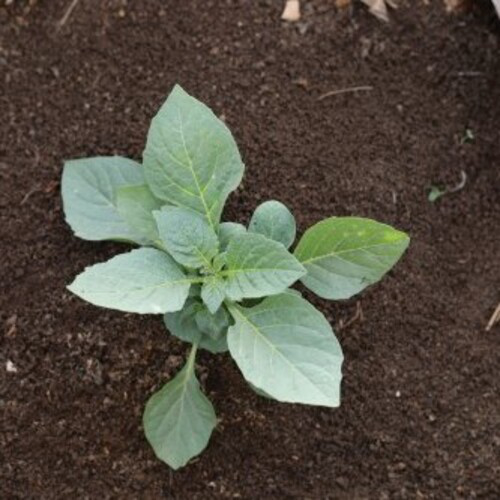

In [35]:
img.detach()
mask.detach()
output.detach()

n = 0
val_img = img[n]
val_mask = mask[n]
pred = output[n]
invtransform = transforms.Compose([transforms.Normalize([0.,0.,0.], [1/0.229,1/0.224,1/0.225]),
                                  transforms.Normalize([-0.485, -0.456, -0.406], [1.,1.,1.])])
val_img = invtransform(val_img)
val_img = unloader(val_img)
val_img

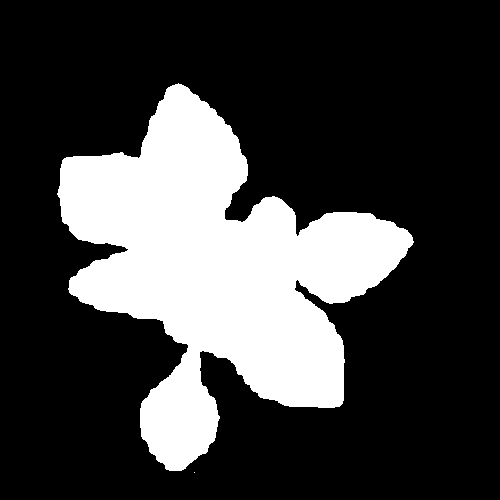

In [36]:
pred[pred>0.1] = 1
pred[pred<0.1] = 0
unloader(pred)

In [37]:
criterion = torch.nn.MSELoss()
criterion(pred, val_mask)

tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward>)